# NNFL Assignment 2 (Fall '21)
You have been given a set of videos (coloured) labeled either as "fire" or "not_fire". Your task to process this data as you see fit and create a model that will classify the unlabeled data present in the test folder. This time, the temporal correlations between frames of a video have to be exploited.

In [ ]:
import cv2
import os
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import seaborn as sns
import pandas as pd
import numpy as np
from numpy import newaxis
import keras
import os, random, shutil, cv2
from shutil import copyfile, copy
from keras import applications,activations
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from keras import optimizers,utils
from keras.models import Sequential, Model 
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,BatchNormalization,ZeroPadding2D, Input, SeparableConv2D
from keras.layers import Conv2D, Conv3D, Activation, MaxPooling2D, MaxPool3D, ConvLSTM2D, MaxPooling3D, TimeDistributed, LSTM
from keras import backend as k 
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping, ReduceLROnPlateau

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Data Preprocessing

In [ ]:
# Extract frames from training videos, and storing them in another directory "train_frames"

path = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/train'
path1  = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/train_frames'
train_list = []

for obj in os.listdir(path):                  # Iterating over videos in the directory
    x = obj.split('.')
    loc =  os.path.join(path,obj)
    loc1 =  os.path.join(path1,x[0])
    vidObj = cv2.VideoCapture(loc)
    count = 0                                   # Used as counter variable
    success = 1
    while success:                              # Reading all frames of a particular video (vidObj)
        success, image = vidObj.read()
        if success == 1:
            path_name = loc1 + '_' + str(count)+'.jpg'
            if not os.path.exists(path_name):
                cv2.imwrite(path_name, image)
            count += 1

        else:
            if count < 5:
                success = 1

            else:
                break

    train_list.append((x[0],count))
    print(x[0], '--> ', count)                  # Prints no. of frames per video     
    vidObj.release()

print(train_list)

1_16 -->  150
1_18 -->  90
1_15 -->  90
1_11 -->  120
1_14 -->  90
1_13 -->  90
1_1 -->  102
1_17 -->  255
1_12 -->  280
1_10 -->  120
1_19 -->  242
1_2 -->  167
1_25 -->  89
1_29 -->  94
1_21 -->  259
1_26 -->  163
1_27 -->  88
1_22 -->  60
1_23 -->  198
1_28 -->  90
1_20 -->  221
1_24 -->  198
1_34 -->  393
1_31 -->  60
1_3 -->  109
1_32 -->  147
1_36 -->  128
1_30 -->  57
1_37 -->  134
1_39 -->  120
1_33 -->  103
1_35 -->  287
1_38 -->  296
1_48 -->  1201
1_42 -->  120
1_41 -->  330
1_47 -->  208
1_43 -->  140
1_44 -->  439
1_4 -->  150
1_45 -->  260
1_46 -->  246
1_40 -->  121
1_53 -->  219
1_57 -->  510
1_49 -->  708
1_52 -->  255
1_51 -->  245
1_5 -->  90
1_56 -->  293
1_50 -->  200
1_54 -->  216
1_59 -->  1655
1_55 -->  218
1_58 -->  381
1_61 -->  258
1_63 -->  513
1_60 -->  2406
1_6 -->  120
1_62 -->  547
2_2 -->  216
2_12 -->  216
2_14 -->  99
2_18 -->  143
2_1 -->  84
2_19 -->  96
2_20 -->  305
2_16 -->  120
2_13 -->  303
2_17 -->  167
2_15 -->  235
2_11 -->  402
2_10 -->  21

In [ ]:
df_train = pd.read_csv('/content/gdrive/MyDrive/nnfl-2021-assignment-2/train.csv')
df_train.head()

,File,True_Label
0,1_1.avi,fire
1,1_10.avi,fire
2,1_11.avi,fire
3,1_12.avi,fire
4,1_13.avi,fire


In [ ]:
df_train.info

<bound method DataFrame.info of          File True_Label
0     1_1.avi       fire
1    1_10.avi       fire
2    1_11.avi       fire
3    1_12.avi       fire
4    1_13.avi       fire
..        ...        ...
115   2_6.avi   not_fire
116  2_60.avi   not_fire
117  2_61.avi   not_fire
118  2_62.avi   not_fire
119  2_63.avi   not_fire

[120 rows x 2 columns]>

In [ ]:
# Lists, fire and not_fire contain the video number of videos in their corresponding category
fire = []
not_fire = []

for i in range(len(df_train)):
    file_name = df_train.loc[i,'File'].split('.')[0]
    if df_train.loc[i,"True_Label"]=="fire":
      fire.append(file_name)

    else:
      not_fire.append(file_name)

print(fire)
print(len(fire))
print(len(not_fire))

# Equally distributed in terms of classes. Hence, no need to specifically handle data imbalance.

['1_1', '1_10', '1_11', '1_12', '1_13', '1_14', '1_15', '1_16', '1_17', '1_18', '1_19', '1_2', '1_20', '1_21', '1_22', '1_23', '1_24', '1_25', '1_26', '1_27', '1_28', '1_29', '1_3', '1_30', '1_31', '1_32', '1_33', '1_34', '1_35', '1_36', '1_37', '1_38', '1_39', '1_4', '1_40', '1_41', '1_42', '1_43', '1_44', '1_45', '1_46', '1_47', '1_48', '1_49', '1_5', '1_50', '1_51', '1_52', '1_53', '1_54', '1_55', '1_56', '1_57', '1_58', '1_59', '1_6', '1_60', '1_61', '1_62', '1_63']
60
60


In [ ]:
print(train_list[:5])               # Printing just to see a few samples
print(len(train_list))
total_img = 0
for i in train_list:
    total_img += int(i[1])

print(total_img)                    # Total images/frames across all videos

[['1_16' '150']
 ['1_18' '90']
 ['1_15' '90']
 ['1_11' '120']
 ['1_14' '90']]
120
64532


In [ ]:
# Getting all frames for each video, and storing them in a list of lists.

path1  = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/train_frames'

all_files = [f for f in os.listdir(path1)]
get_frames = [[] for i in range(len(train_list))]
print(all_files)

temp = [i[0] for i in train_list]

for _file in all_files:
    file_name = _file.split('_')
    video_name = file_name[0]+"_"+file_name[1]
    try:
        get_frames[temp.index(video_name)].append(_file)
    except:
        pass

# get_frames will be a list of lists, where each list contains names of all frames of a video. get_frames[i] contains frames of train_list[i][0] video.

In [ ]:
print(len(all_files))                   # total files...since it matches with the count of train_list, nothing has been missed
print(len(get_frames))                  # should be 120 (equal to number of videos)

64532
120


In [ ]:
# req_frames contains 10 frames per video in the same order as train_list. So, req_frames[i] will have names of 10 equally spaced frames of video
# train_list[i][0]
req_frames = []
for i in range(len(get_frames)):
    x = len(get_frames[i]) // 10
    req_frames.append([])

    for j in range(0,len(get_frames[i]),x):               # taking frames over interval of x, so that they are equally spaced
        req_frames[-1].append(get_frames[i][j])
        if len(req_frames[-1]) == 10:
            break

In [ ]:
# data and labels, are 2 lists (later converted to numpy arrays), that contain the exact data to be fed into a model for training. Now that we know
# which frames we want from a video, we simply iterate over the directory, find that frame (image), convert it into an array, and store it. Later,
# since we want to exploit the temporal correlation between frames of a video, we simply concatenate the frames depthwise. 

data = []
labels = []
directory = "/content/gdrive/MyDrive/nnfl-2021-assignment-2/train_frames"

for i in range(len(train_list)):
    video_num = train_list[i][0]
    frames = []                                                   # contains the numpy arrays of images belonging to this video that we would be using
    for j in range(len(req_frames[i])):
        for filename in os.listdir(directory):                    # Iterate over the entire directory to find images of a particular video
            f = os.path.join(directory, filename)
            image_name = f.split('/')[6]

            if image_name==req_frames[i][j]:
                img_arr = img_to_array(load_img(directory+'/'+image_name, target_size=(128,128)))
                frames.append(img_arr)
                break

    final = np.concatenate([frames], axis=0)                      # concatenate frames depthwise
    data.append(final)

    if video_num in fire:
        labels.append(1)
    else:
        labels.append(0)                

In [ ]:
# Converting lists to numpy arrays, and normalizing data
data = np.array(data)
labels = np.array(labels)
data = data / 255.

In [ ]:
print(data.shape)              
print(labels.shape)             
print(np.unique(labels, return_counts=True))

(120, 10, 128, 128, 3)
(120,)
(array([0, 1]), array([60, 60]))


In [ ]:
# OHE the labels, and dividing data into training and validation in the ratio 75:25
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
labels = np_utils.to_categorical(labels, 2)

(trainX, valX, trainY, valY) = train_test_split(data, labels, test_size=0.25, stratify=labels)

In [ ]:
print(trainX.shape)
print(valX.shape)
print(trainY.shape)

(90, 10, 256, 256, 3)
(30, 10, 256, 256, 3)
(90, 2)


## Model Architecture and Training

###CNN-LSTM

In [ ]:
model = Sequential()
model.add(ConvLSTM2D(32, kernel_size=(3, 3), strides=(1,1), return_sequences=True, activation='relu', input_shape=(10, 128, 128, 3)))
model.add(MaxPooling3D((1,2,2)))

model.add(Flatten())

model.add(Dense(64, activation='relu'))
model.add(Dropout(.3))

model.add(Dense(2, activation='softmax'))

In [ ]:
from keras.callbacks import ReduceLROnPlateau
model.compile(optimizer = tf.keras.optimizers.Adam(0.003), loss='categorical_crossentropy', metrics =['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

In [ ]:
model_fit = model.fit(trainX, trainY, epochs=24, batch_size=16, steps_per_epoch=len(trainX)//16, validation_data=(valX, valY), callbacks=[reduce_lr])

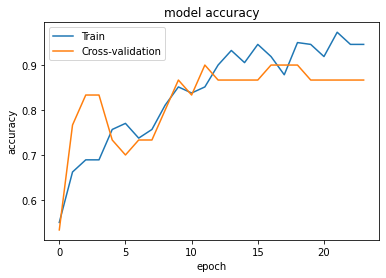

In [ ]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

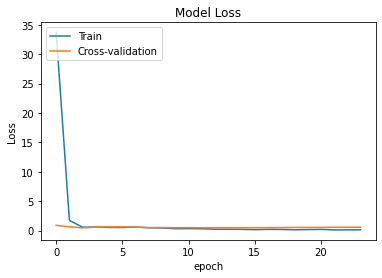

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

###CNN+LSTM (Time distributed)

In [ ]:
model = Sequential()
model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu'), input_shape=(10, 128, 128, 3)))
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2,2))))

model.add(TimeDistributed(Flatten()))
model.add(Dropout(.4))

model.add(LSTM(32, activation='relu', dropout=0.4, return_sequences=False))

model.add(Dense(96, activation='relu'))
model.add(Dropout(.4))

model.add(Dense(32, activation='relu'))
model.add(Dropout(.3))

model.add(Dense(2, activation='softmax'))

In [ ]:
from keras.callbacks import ReduceLROnPlateau
model.compile(optimizer = tf.keras.optimizers.Adam(0.003), loss='categorical_crossentropy', metrics =['accuracy'])
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.0001)

In [ ]:
model_fit = model.fit(trainX, trainY, epochs=24, batch_size=16, steps_per_epoch=len(trainX)//16, validation_data=(valX, valY), callbacks=[reduce_lr])

Epoch 1/24
5/5 [==============================] - 8s 838ms/step - loss: 11.6957 - accuracy: 0.6000 - val_loss: 1.0469 - val_accuracy: 0.4667 - lr: 0.0030
Epoch 2/24
5/5 [==============================] - 3s 446ms/step - loss: 1.1937 - accuracy: 0.4865 - val_loss: 0.6927 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 3/24
5/5 [==============================] - 2s 412ms/step - loss: 0.6905 - accuracy: 0.5000 - val_loss: 0.6871 - val_accuracy: 0.5000 - lr: 0.0030
Epoch 4/24
5/5 [==============================] - 2s 407ms/step - loss: 0.6646 - accuracy: 0.5676 - val_loss: 0.5821 - val_accuracy: 0.6667 - lr: 0.0030
Epoch 5/24
5/5 [==============================] - 2s 410ms/step - loss: 0.6251 - accuracy: 0.5946 - val_loss: 0.6765 - val_accuracy: 0.5667 - lr: 0.0030
Epoch 6/24
5/5 [==============================] - 2s 411ms/step - loss: 0.7527 - accuracy: 0.5000 - val_loss: 0.6741 - val_accuracy: 0.6000 - lr: 0.0030
Epoch 7/24
5/5 [==============================] - 2s 442ms/step - loss: 0.6077 - 

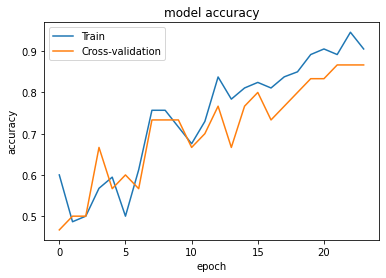

In [ ]:
plt.plot(model_fit.history['accuracy'])
plt.plot(model_fit.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

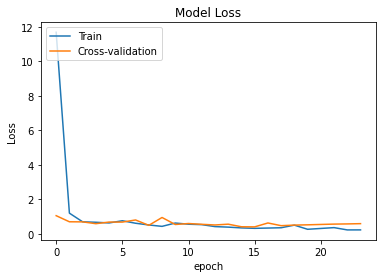

In [ ]:
plt.plot(model_fit.history['loss'])
plt.plot(model_fit.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Cross-validation'], loc='upper left')
plt.show()

## Testing and making predictions

In [ ]:
df_test = pd.read_csv('/content/gdrive/MyDrive/nnfl-2021-assignment-2/test.csv')
df_test.head()

,File
0,2_7.avi
1,2_65.avi
2,1_65.avi
3,1_69.avi
4,1_9.avi


In [ ]:
df_test.info

<bound method DataFrame.info of         File
0    2_7.avi
1   2_65.avi
2   1_65.avi
3   1_69.avi
4    1_9.avi
5   2_64.avi
6    1_7.avi
7    1_8.avi
8    2_8.avi
9    2_9.avi
10  1_68.avi
11  2_70.avi
12  2_66.avi
13  2_69.avi
14  1_66.avi
15  2_68.avi
16  1_64.avi
17  2_67.avi
18  1_70.avi
19  1_67.avi>

In [ ]:
# Extract frames from testing videos, in order to make predictions, and store them in the directory "test_frames"...code is similar to that of training
# videos

path = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/test'
path1  = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/test_frames'
test_list = []

for obj in os.listdir(path):                  # Iterating over videos in the directory
    x = obj.split('.')
    loc =  os.path.join(path,obj)
    loc1 =  os.path.join(path1,x[0])
    vidObj = cv2.VideoCapture(loc)
    count = 0                                   # Used as counter variable
    success = 1
    while success:                              # Reading all frames of a particular video (vidObj)
        success, image = vidObj.read()
        if success == 1:
            path_name_test = loc1 + '_' + str(count)+'.jpg'
            if not os.path.exists(path_name_test):
                cv2.imwrite(path_name_test, image)
            count += 1

        else:
            if count < 5:
                success = 1

            else:
                break

    test_list.append((x[0],count))
    print(x[0], '--> ', count)                  # Prints no. of frames per video     
    vidObj.release()

print(test_list)

1_64 -->  663
1_7 -->  65
1_9 -->  30
1_68 -->  268
2_65 -->  2840
1_67 -->  42
1_70 -->  64
1_8 -->  150
1_66 -->  178
1_69 -->  109
2_64 -->  251
1_65 -->  235
2_67 -->  776
2_66 -->  251
2_68 -->  191
2_69 -->  394
2_70 -->  102
2_9 -->  147
2_8 -->  158
2_7 -->  324
[('1_64', 663), ('1_7', 65), ('1_9', 30), ('1_68', 268), ('2_65', 2840), ('1_67', 42), ('1_70', 64), ('1_8', 150), ('1_66', 178), ('1_69', 109), ('2_64', 251), ('1_65', 235), ('2_67', 776), ('2_66', 251), ('2_68', 191), ('2_69', 394), ('2_70', 102), ('2_9', 147), ('2_8', 158), ('2_7', 324)]


In [ ]:
print(len(test_list))               # Equal to number of testing videos
total_img = 0
for i in test_list:
    total_img += int(i[1])

print(total_img)                    # Total images/frames across all testing videos

20
7238


In [ ]:
# Getting all frames for each test video, and storing them in a list of lists.

path1  = '/content/gdrive/MyDrive/nnfl-2021-assignment-2/test_frames'

all_files_test = [f for f in os.listdir(path1)]
get_frames_test = [[] for i in range(len(test_list))]
print(all_files_test)

temp = [i[0] for i in test_list]

for _file in all_files_test:
    file_name = _file.split('_')
    video_name = file_name[0]+"_"+file_name[1]
    try:
        get_frames_test[temp.index(video_name)].append(_file)
        
    except:
        pass

print(get_frames_test)      # get_frames_test will be a list of lists, where each list contains names of all frames of a video. get_frames_test[i] contains frames of test_list[i][0] video.

In [ ]:
print(len(all_files_test))                   
print(len(get_frames_test))                 

11039
20


In [ ]:
# req_frames_test contains 10 frames per video in the same order as test_list. So, req_frames_test[i] will have names of 10 equally spaced frames of
# video test_list[i][0]
req_frames_test = []
for i in range(len(get_frames_test)):
    x = len(get_frames_test[i]) // 10
    req_frames_test.append([])

    for j in range(0,len(get_frames_test[i]),x):               # taking frames over interval of x, so that they are equally spaced
        req_frames_test[-1].append(get_frames_test[i][j])
        if len(req_frames_test[-1]) == 10:
            break

In [ ]:
data_test = []
directory = "/content/gdrive/MyDrive/nnfl-2021-assignment-2/test_frames"

for i in range(len(test_list)):
    video_num = test_list[i][0]
    frames = []                                                   # contains the numpy arrays of images belonging to this video that we would be using
    for j in range(len(req_frames_test[i])):
        for filename in os.listdir(directory):                    # Iterate over the entire directory to find images of a particular video
            f = os.path.join(directory, filename)
            image_name = f.split('/')[6]

            if image_name==req_frames_test[i][j]:
                img_arr = img_to_array(load_img(directory+'/'+image_name, target_size=(128,128)))
                frames.append(img_arr)
                break

    final = np.concatenate([frames], axis=0)                      # concatenate frames depthwise
    data_test.append(final)             

In [ ]:
data_test = np.array(data_test)
data_test = data_test / 255.

In [ ]:
print(data_test.shape)              

(20, 10, 128, 128, 3)


In [ ]:
# Remember: fire-1 , not_fire-0
predict = model.predict(data_test)
y_classes = predict.argmax(axis=-1) 

In [ ]:
df_test.head()

,File
0,2_7.avi
1,2_65.avi
2,1_65.avi
3,1_69.avi
4,1_9.avi


In [ ]:
df_sub = pd.read_csv('/content/gdrive/MyDrive/nnfl-2021-assignment-2/Sample Submission.csv')
df_sub.head()

,File,Label
0,2_7.avi,not_fire
1,2_65.avi,not_fire
2,1_65.avi,not_fire
3,1_69.avi,not_fire
4,1_9.avi,not_fire


In [ ]:
actual_sub = df_sub.copy()

In [ ]:
for i in range(len(actual_sub)):
    if y_classes[i]==1:
        actual_sub.loc[i, "Label"] = "fire"
    else:
        actual_sub.loc[i, "Label"] = "not_fire"

In [ ]:
# Saving the dataframe to a CSV file, so that it can be uploaded on Kaggle
actual_sub.to_csv('/content/gdrive/MyDrive/nnfl-2021-assignment-2/sub.csv', index=False)